# ニューラルネットワークを分岐させずにMulti-task learning

In [1]:
import os
gpu_num = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

In [2]:
# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.
/home/tmp10014/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file


### Tox21の画像パスとラベル取得

In [3]:
# ラベル情報などが書いたcsvファイル（tox21_compoundData.csv）
csv_path = r'../storage/tox21_compoundData.csv'

# IDにファイルのフルパスつける
img_dir = r'../storage/img/Wash/331x331/'

# 画像ファイルのサフィックス
img_suffix = r'_000.jpg'

# 欠損値を-1に置換したtox21_compoundData.csvのデータフレーム
df = prepare_data.make_label_df(csv_path, img_dir, img_suffix=img_suffix)

# Tox21の画像のパスとラベル(y_train,y_valid,y_test)を取得する
train_files, validation_files, test_files, y_train, y_valid, y_test = prepare_data.make_train_val_test(df)

training_set_y.shape: (11764, 12)
validation_set_y.shape: (296, 12)
test_set_y.shape: (647, 12)


### パラメータ設定
- 画像サイズ: 331x331
- エポック数: 250
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル: SEInceptionV3
    - 全結合層: 1層（各層のニューロンの数は1024。各層にdropoutを0.5倍、重みの初期値はhe_normal(He の正規分布)、L2正則化=1e-4）
    - 重みは全層学習させる（fine-tuningなし）
    - 出力層の活性化関数: sigmoid（マルチラベルなので）
    - 出力層の重みの初期値はzero
- オプティマイザ: SGD
    - 学習率: 0.01
- データ水増し
    - 画像の剪断（shear_range=0.2）
    - 拡大縮小（zoom_range=[0.5, 1.9]）
    - 回転（rotation_range=60）
    - 上下反転（horizontal_flip=True）
    - 左右反転（vertical_flip=True）
    - 画像の一部矩形領域を隠す（random_erasing)
- callback
    - keras.callbacks.TerminateOnNaN: lossがNaNになった時に訓練を終了する
    - keras.callbacks.ModelCheckpoint: val_loss最少になるモデルを保存する
    - keras.callbacks.EarlyStopping: val_lossが100エポック更新されなければ学習停止する
    - cosine_annealing: lr*0.01 になるまで段階的に学習率下げる
    - keras.callbacks.CSVLogger: 各エポックの結果をcsvファイルに保存する
    

In [4]:
# 出力ディレクトリ
out_dir = 'output_Tox21_test'
os.makedirs(out_dir, exist_ok=True)

# batch_size
train_batch_size=17
valid_batch_size=6

# エポック数
epochs=250

# 入力層のサイズ
shape=[331, 331, 3]

# クラス数
num_classes=12

# Fine-tuning する学習済みモデル
choice_model='SEInceptionV3'# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']

# 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
trainable='all'# [249]

# GradCamでモデルの注目点を切りだす最後の畳み込み層
layer_name = 'multiply_11' #'mixed10'

## 全結合層のパラメータ
# pooling方法
FCpool='GlobalAveragePooling2D'
# 全結像層
FCnum=1 # [None,1,2,3,4,5]
# 全結合層のニューロンの数とdropout rate
Dence_1, Dropout_1, addBatchNorm_1, kernel_initializer_1, l2_rate_1=1024, 0.5, None, 'he_normal', 1e-4

# 出力層の活性化関数
activation = 'sigmoid'
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4

# optimizer のパラメータ
choice_optim='sgd'
lr = 0.01
decay = 0.0

# GPUの数
gpu_count=len(gpu_num.split(','))
print('gpu_count:', gpu_count)

# ImageDataGenerator のデータ水増しオプション
horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

## コールバックの設定
# keras.callbacks.ModelCheckpoint
check_monitor='val_loss' # val_loss最少になるモデルを保存する

# keras.callbacks.EarlyStopping
early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
early_stopping_pati=100


gpu_count: 1


### モデル定義

In [5]:
model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                        , choice_model, trainable
                                                        , FCnum
                                                        , FCpool=FCpool
                                                        , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                        #, Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                        #, Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                        #, Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                        #, Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                        , activation=activation 
                                                        , gpu_count=gpu_count
                                                        #, skip_bn=skip_bn
                                                        )
# オプティマイザ
optim = define_model.get_optimizers(choice_optim, lr=lr, decay=decay)
lr_metric = my_metric.get_lr_metric(optim)

# モデルコンパイル
model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy),
              optimizer=optim,
              metrics=['binary_accuracy', multi_loss.masked_accuracy, lr_metric])

# callback
cb = []

if gpu_count > 1:
    # マルチGPUでModelCheckpoint使うためのコールバック
    weight_dir = os.path.join(out_dir, 'model_weight')
    os.makedirs(weight_dir, exist_ok=True)
    cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))
    
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb.append(keras.callbacks.TerminateOnNaN())
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'best_model.h5'), monitor=check_monitor, save_best_only=True))#, monitor='val_acc'
    cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati , verbose=1))
    # 学習率をエポック増やすごとにコサインカーブのように上げ下げする
    ## 引数なしならlr*0.01まで下げるだけ
    cb.append(my_callback.cosine_annealing())
    
cb.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
print(cb)

----- model_param -----
output_dir = output_Tox21_test
img_rows img_cols channels = 331 331 3
num_classes = 12
choice_model trainable = SEInceptionV3 all
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
choice_optim = sgd
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
[<keras.callbacks.TerminateOnNaN object at 0x7f2e771992e8>, <keras.callbacks.ModelCheckpoint object at 0x7f2e77199f98>, <keras.callbacks.EarlyStopping object at 0x7f2e77199c88>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x7f2e77199278>, <keras.callbacks.CSVLogger object at 0x7f2e76cef9e8>]


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
# モデルのサマリー
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 165, 165, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 165, 165, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
# モデルのレイヤー名と番号
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 global_average_pooling2d_1
42 reshape_1
43 dense_1
44 dense_2
45 multiply_1
46 conv2d_16
47 batch_normalization_16
48 activation_16
49 conv2d_14
50 conv2d_17
51 batch_normalization_14
52 batch_normalization_17
53 activation_14
54 activation_17
55 average_pooling2d_2
56 conv2d_13


### データ管理クラス定義
- d_cls.X_train: train set の画像データ（d_cls.X_train.shape:[11764, 331, 331, 3]）
- d_cls.X_valid: validation set の画像データ（d_cls.X_valid.shape:[296, 331, 331, 3]）
- d_cls.X_test: test set の画像データ（d_cls.X_test.shape:[647, 331, 331, 3]）
- d_cls.train_gen: train set のImageDataGenerator
- d_cls.valid_gen: validation set のImageDataGenerator

In [8]:
%%time
d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.load_train_as_image(train_files, y_train)
d_cls.load_validation_as_image(validation_files, y_valid)
d_cls.load_test_as_image(test_files, y_test)

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             , 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

CPU times: user 52.9 s, sys: 50.7 s, total: 1min 43s
Wall time: 3min 17s


### 学習実行（2日程度かかる）

In [9]:
%%time
model.fit_generator(d_cls.train_gen
                    , steps_per_epoch=d_cls.train_steps_per_epoch()
                    , epochs=epochs
                    , validation_data=d_cls.valid_gen
                    , validation_steps=d_cls.valid_steps_per_epoch()
                    , callbacks=cb
                    , verbose=2)

Epoch 1/250
692/692 [==============================] - 784s 1s/step - loss: 0.3352 - binary_accuracy: 0.6461 - masked_accuracy: 0.9264 - lr: 0.0100 - val_loss: 0.3897 - val_binary_accuracy: 0.8078 - val_masked_accuracy: 0.9158 - val_lr: 0.0100
Epoch 2/250
692/692 [==============================] - 752s 1s/step - loss: 0.3190 - binary_accuracy: 0.6461 - masked_accuracy: 0.9266 - lr: 0.0100 - val_loss: 0.3793 - val_binary_accuracy: 0.8078 - val_masked_accuracy: 0.9158 - val_lr: 0.0100
Epoch 3/250
692/692 [==============================] - 751s 1s/step - loss: 0.3133 - binary_accuracy: 0.6461 - masked_accuracy: 0.9267 - lr: 0.0100 - val_loss: 0.3940 - val_binary_accuracy: 0.8078 - val_masked_accuracy: 0.9158 - val_lr: 0.0100
Epoch 4/250
692/692 [==============================] - 751s 1s/step - loss: 0.3078 - binary_accuracy: 0.6461 - masked_accuracy: 0.9264 - lr: 0.0100 - val_loss: 0.3771 - val_binary_accuracy: 0.8078 - val_masked_accuracy: 0.9158 - val_lr: 0.0100
Epoch 5/250
692/692 [===

692/692 [==============================] - 752s 1s/step - loss: 0.1613 - binary_accuracy: 0.6517 - masked_accuracy: 0.9346 - lr: 0.0083 - val_loss: 0.2596 - val_binary_accuracy: 0.8047 - val_masked_accuracy: 0.9119 - val_lr: 0.0083
Epoch 68/250
692/692 [==============================] - 752s 1s/step - loss: 0.1599 - binary_accuracy: 0.6518 - masked_accuracy: 0.9349 - lr: 0.0083 - val_loss: 0.2584 - val_binary_accuracy: 0.8098 - val_masked_accuracy: 0.9180 - val_lr: 0.0083
Epoch 69/250
692/692 [==============================] - 752s 1s/step - loss: 0.1594 - binary_accuracy: 0.6518 - masked_accuracy: 0.9349 - lr: 0.0083 - val_loss: 0.2408 - val_binary_accuracy: 0.8112 - val_masked_accuracy: 0.9196 - val_lr: 0.0083
Epoch 70/250
692/692 [==============================] - 751s 1s/step - loss: 0.1590 - binary_accuracy: 0.6522 - masked_accuracy: 0.9352 - lr: 0.0082 - val_loss: 0.2395 - val_binary_accuracy: 0.8098 - val_masked_accuracy: 0.9182 - val_lr: 0.0082
Epoch 71/250
692/692 [===========

692/692 [==============================] - 751s 1s/step - loss: 0.1279 - binary_accuracy: 0.6564 - masked_accuracy: 0.9415 - lr: 0.0046 - val_loss: 0.2241 - val_binary_accuracy: 0.8061 - val_masked_accuracy: 0.9142 - val_lr: 0.0046
Epoch 134/250
692/692 [==============================] - 752s 1s/step - loss: 0.1265 - binary_accuracy: 0.6568 - masked_accuracy: 0.9421 - lr: 0.0045 - val_loss: 0.2234 - val_binary_accuracy: 0.8090 - val_masked_accuracy: 0.9170 - val_lr: 0.0045
Epoch 135/250
692/692 [==============================] - 751s 1s/step - loss: 0.1264 - binary_accuracy: 0.6570 - masked_accuracy: 0.9426 - lr: 0.0044 - val_loss: 0.2286 - val_binary_accuracy: 0.8098 - val_masked_accuracy: 0.9179 - val_lr: 0.0044
Epoch 136/250
692/692 [==============================] - 750s 1s/step - loss: 0.1253 - binary_accuracy: 0.6566 - masked_accuracy: 0.9416 - lr: 0.0044 - val_loss: 0.2286 - val_binary_accuracy: 0.8073 - val_masked_accuracy: 0.9154 - val_lr: 0.0044
Epoch 137/250
692/692 [=======

692/692 [==============================] - 753s 1s/step - loss: 0.1104 - binary_accuracy: 0.6612 - masked_accuracy: 0.9485 - lr: 0.0011 - val_loss: 0.2346 - val_binary_accuracy: 0.8002 - val_masked_accuracy: 0.9072 - val_lr: 0.0011
Epoch 200/250
692/692 [==============================] - 753s 1s/step - loss: 0.1106 - binary_accuracy: 0.6606 - masked_accuracy: 0.9478 - lr: 0.0010 - val_loss: 0.2243 - val_binary_accuracy: 0.8075 - val_masked_accuracy: 0.9154 - val_lr: 0.0010
Epoch 201/250
692/692 [==============================] - 753s 1s/step - loss: 0.1095 - binary_accuracy: 0.6619 - masked_accuracy: 0.9494 - lr: 0.0010 - val_loss: 0.2269 - val_binary_accuracy: 0.8067 - val_masked_accuracy: 0.9145 - val_lr: 0.0010
Epoch 202/250
692/692 [==============================] - 753s 1s/step - loss: 0.1110 - binary_accuracy: 0.6610 - masked_accuracy: 0.9482 - lr: 9.7351e-04 - val_loss: 0.2237 - val_binary_accuracy: 0.8022 - val_masked_accuracy: 0.9093 - val_lr: 9.7351e-04
Epoch 203/250
692/692 

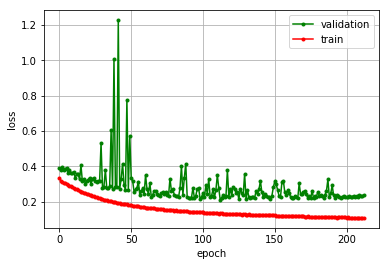

<Figure size 432x288 with 0 Axes>

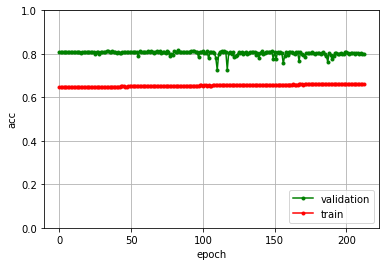

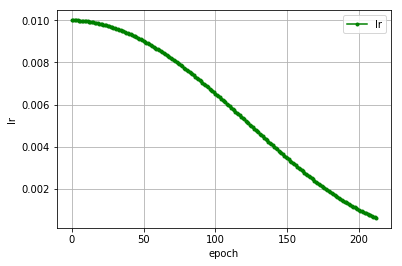

<Figure size 432x288 with 0 Axes>

In [10]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))

### 推論実行

### test set
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/test ディレクトリに出力

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task0
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       537
           1       0.53      0.53      0.53        73
          -1       0.00      0.00      0.00        37

   micro avg       0.85      0.85      0.85       647
   macro avg       0.47      0.49      0.48       647
weighted avg       0.80      0.85      0.82       647

Confusion matrix, without normalization


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


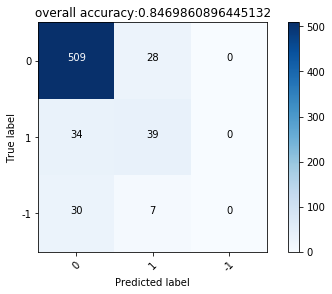

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task1
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       574
           1       0.50      0.17      0.25        12
          -1       0.00      0.00      0.00        61

   micro avg       0.89      0.89      0.89       647
   macro avg       0.46      0.39      0.40       647
weighted avg       0.80      0.89      0.84       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

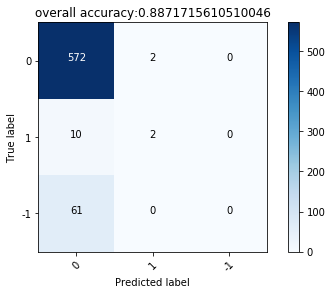

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task2
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       574
           1       0.00      0.00      0.00         8
          -1       0.00      0.00      0.00        65

   micro avg       0.88      0.88      0.88       647
   macro avg       0.30      0.33      0.31       647
weighted avg       0.79      0.88      0.83       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

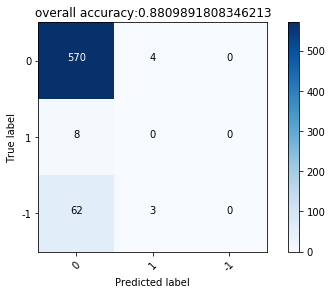

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task3
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       489
           1       0.27      0.15      0.20        39
          -1       0.00      0.00      0.00       119

   micro avg       0.76      0.76      0.76       647
   macro avg       0.35      0.38      0.36       647
weighted avg       0.60      0.76      0.67       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

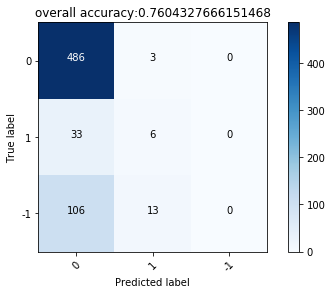

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task4
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       465
           1       0.54      0.25      0.35        51
          -1       0.00      0.00      0.00       131

   micro avg       0.73      0.73      0.73       647
   macro avg       0.43      0.41      0.40       647
weighted avg       0.57      0.73      0.63       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

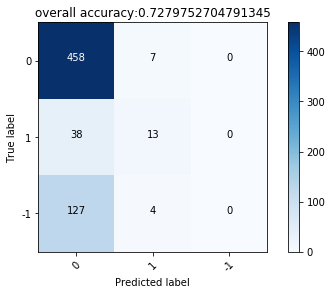

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task5
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       580
           1       0.27      0.15      0.19        20
          -1       0.00      0.00      0.00        47

   micro avg       0.89      0.89      0.89       647
   macro avg       0.39      0.38      0.38       647
weighted avg       0.82      0.89      0.85       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

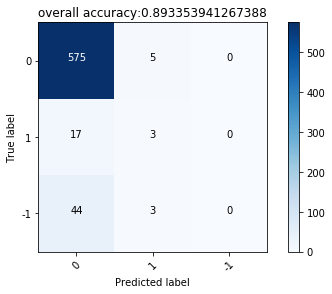

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task6
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       574
           1       0.00      0.00      0.00        31
          -1       0.00      0.00      0.00        42

   micro avg       0.88      0.88      0.88       647
   macro avg       0.30      0.33      0.31       647
weighted avg       0.79      0.88      0.83       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

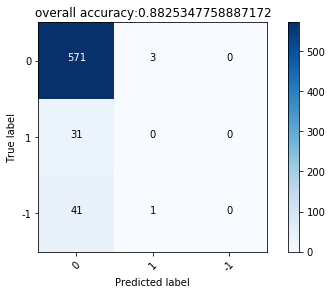

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task7
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       462
           1       0.38      0.32      0.35        93
          -1       0.00      0.00      0.00        92

   micro avg       0.71      0.71      0.71       647
   macro avg       0.38      0.42      0.40       647
weighted avg       0.60      0.71      0.65       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

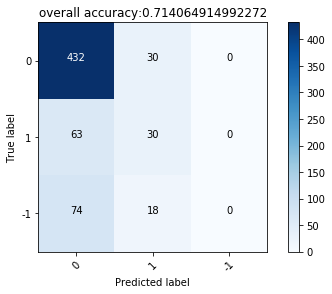

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task8
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       584
           1       0.36      0.11      0.16        38
          -1       0.00      0.00      0.00        25

   micro avg       0.90      0.90      0.90       647
   macro avg       0.42      0.36      0.37       647
weighted avg       0.84      0.90      0.86       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

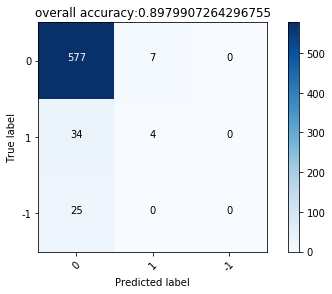

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task9
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       588
           1       0.27      0.27      0.27        22
          -1       0.00      0.00      0.00        37

   micro avg       0.90      0.90      0.90       647
   macro avg       0.40      0.42      0.41       647
weighted avg       0.85      0.90      0.87       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

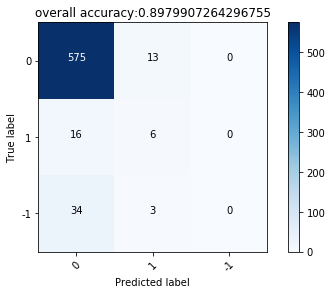

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task10
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       483
           1       0.33      0.55      0.42        60
          -1       0.00      0.00      0.00       104

   micro avg       0.75      0.75      0.75       647
   macro avg       0.39      0.50      0.43       647
weighted avg       0.65      0.75      0.70       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

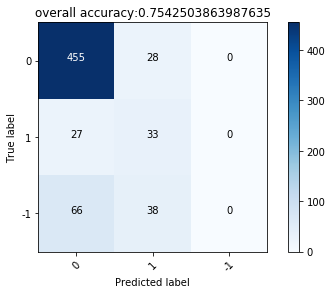

------------------------------------
out_dir: output_Tox21_test/predict/test/confusion_matrix/task11
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       575
           1       0.11      0.07      0.09        41
          -1       0.00      0.00      0.00        31

   micro avg       0.86      0.86      0.86       647
   macro avg       0.34      0.35      0.34       647
weighted avg       0.81      0.86      0.83       647

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

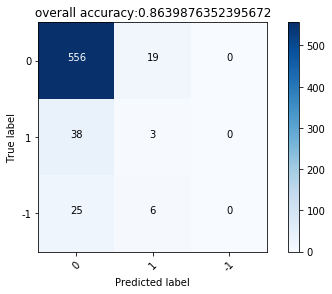

CPU times: user 24.1 s, sys: 8.38 s, total: 32.5 s
Wall time: 27.7 s


<Figure size 432x288 with 0 Axes>

In [11]:
%%time
# -------- 推論 --------
model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/test')

# 出力層のニューラルネットワークに分岐がない場合のpredict
y_test_list, y_pred_list = multi_predict.no_branch_set_predict(model, d_cls.X_test, d_cls.y_test, out_predict_dir)

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
classes = [0,1,-1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(classes, y_test_list, y_pred_list, out_predict_dir)

------------------------------------
out_png: output_Tox21_test/predict/test/ROC_curve.png


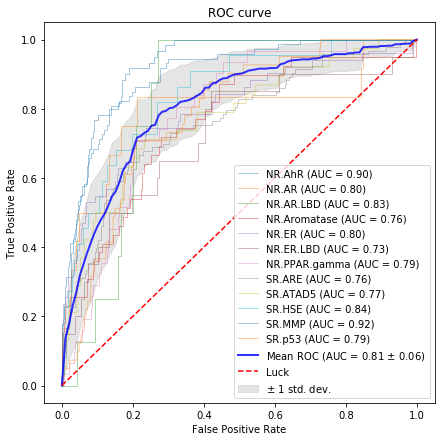

<Figure size 432x288 with 0 Axes>

In [12]:
# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list)

### test set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/../predicter/grad_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()# camのピクセルの値を0-1に正規化


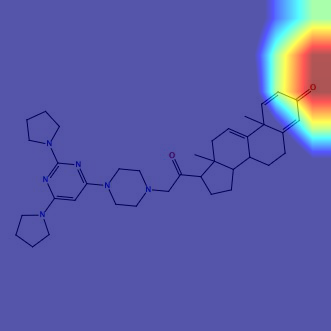

In [13]:
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test')

model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_test[0]*255.0
input_img_name = 'test0'

y_true = d_cls.y_test[0]

# 1画像について各タスクのGradCamを計算
grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### test set 全件GradCam実行（十数時間かかる）

input_img_name: NCGC00261900-01_000.jpg


/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/../predicter/grad_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()# camのピクセルの値を0-1に正規化


input_img_name: NCGC00260869-01_000.jpg
input_img_name: NCGC00261776-01_000.jpg
input_img_name: NCGC00261380-01_000.jpg
input_img_name: NCGC00261842-01_000.jpg
input_img_name: NCGC00261662-01_000.jpg
input_img_name: NCGC00261190-01_000.jpg
input_img_name: NCGC00260731-01_000.jpg
input_img_name: NCGC00261926-01_000.jpg
input_img_name: NCGC00261579-01_000.jpg
input_img_name: NCGC00260921-01_000.jpg
input_img_name: NCGC00261119-01_000.jpg
input_img_name: NCGC00260957-01_000.jpg
input_img_name: NCGC00261812-01_000.jpg
input_img_name: NCGC00260831-01_000.jpg
input_img_name: NCGC00261544-01_000.jpg
input_img_name: NCGC00261619-01_000.jpg
input_img_name: NCGC00261633-01_000.jpg
input_img_name: NCGC00261395-01_000.jpg
input_img_name: NCGC00261717-01_000.jpg
input_img_name: NCGC00261947-01_000.jpg
input_img_name: NCGC00261424-01_000.jpg
input_img_name: NCGC00261861-01_000.jpg
input_img_name: NCGC00261924-01_000.jpg
input_img_name: NCGC00261052-01_000.jpg
input_img_name: NCGC00261683-01_000.jpg


input_img_name: NCGC00261545-01_000.jpg
input_img_name: NCGC00261480-01_000.jpg
input_img_name: NCGC00261838-01_000.jpg
input_img_name: NCGC00261627-01_000.jpg
input_img_name: NCGC00261639-01_000.jpg
input_img_name: NCGC00261177-01_000.jpg
input_img_name: NCGC00260692-01_000.jpg
input_img_name: NCGC00260775-01_000.jpg
input_img_name: NCGC00260876-01_000.jpg
input_img_name: NCGC00261598-01_000.jpg
input_img_name: NCGC00260707-01_000.jpg
input_img_name: NCGC00261554-01_000.jpg
input_img_name: NCGC00261713-01_000.jpg
input_img_name: NCGC00261737-01_000.jpg
input_img_name: NCGC00261882-01_000.jpg
input_img_name: NCGC00261933-01_000.jpg
input_img_name: NCGC00261201-01_000.jpg
input_img_name: NCGC00261398-01_000.jpg
input_img_name: NCGC00261601-01_000.jpg
input_img_name: NCGC00261003-01_000.jpg
input_img_name: NCGC00261019-01_000.jpg
input_img_name: NCGC00261519-01_000.jpg
input_img_name: NCGC00261732-01_000.jpg
input_img_name: NCGC00261718-01_000.jpg
input_img_name: NCGC00260743-01_000.jpg


input_img_name: NCGC00357169-01_000.jpg
input_img_name: NCGC00357022-01_000.jpg
input_img_name: NCGC00357165-01_000.jpg
input_img_name: NCGC00357122-01_000.jpg
input_img_name: NCGC00357212-01_000.jpg
input_img_name: NCGC00357263-01_000.jpg
input_img_name: NCGC00357052-01_000.jpg
input_img_name: NCGC00356952-01_000.jpg
input_img_name: NCGC00357225-01_000.jpg
input_img_name: NCGC00357105-01_000.jpg
input_img_name: NCGC00356944-01_000.jpg
input_img_name: NCGC00356977-01_000.jpg
input_img_name: NCGC00357053-01_000.jpg
input_img_name: NCGC00357202-01_000.jpg
input_img_name: NCGC00357013-01_000.jpg
input_img_name: NCGC00357131-01_000.jpg
input_img_name: NCGC00357127-01_000.jpg
input_img_name: NCGC00357147-01_000.jpg
input_img_name: NCGC00357267-01_000.jpg
input_img_name: NCGC00356979-01_000.jpg
input_img_name: NCGC00357179-01_000.jpg
input_img_name: NCGC00356945-01_000.jpg
input_img_name: NCGC00357068-01_000.jpg
input_img_name: NCGC00357002-01_000.jpg
input_img_name: NCGC00356974-01_000.jpg


input_img_name: NCGC00357250-01_000.jpg
input_img_name: NCGC00357227-01_000.jpg
input_img_name: NCGC00356997-01_000.jpg
input_img_name: NCGC00356998-01_000.jpg
input_img_name: NCGC00357282-01_000.jpg
input_img_name: NCGC00357029-01_000.jpg
input_img_name: NCGC00356948-01_000.jpg
input_img_name: NCGC00357054-01_000.jpg
input_img_name: NCGC00356956-01_000.jpg
input_img_name: NCGC00356994-01_000.jpg
input_img_name: NCGC00356949-01_000.jpg
input_img_name: NCGC00357234-01_000.jpg
input_img_name: NCGC00356967-01_000.jpg
input_img_name: NCGC00357111-01_000.jpg
input_img_name: NCGC00357155-01_000.jpg
input_img_name: NCGC00357098-01_000.jpg
input_img_name: NCGC00357156-01_000.jpg
input_img_name: NCGC00357019-01_000.jpg
input_img_name: NCGC00357095-01_000.jpg
input_img_name: NCGC00357226-01_000.jpg
input_img_name: NCGC00357249-01_000.jpg
input_img_name: NCGC00357017-01_000.jpg
input_img_name: NCGC00357259-01_000.jpg
input_img_name: NCGC00357051-01_000.jpg
input_img_name: NCGC00356954-01_000.jpg


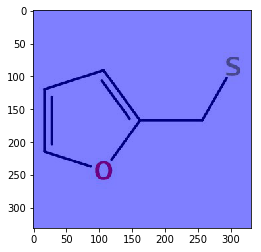

CPU times: user 14h 55min 4s, sys: 25min 10s, total: 15h 20min 14s
Wall time: 14h 59min 27s


In [14]:
%%time
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test_all')

model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

for i,  x in enumerate(d_cls.X_test):
    # 3次元numpy.array型の画像データ（*1./255.前）
    x = x*255.0

    # ファイル名
    file_path = test_files[test_files.index[i]]# test_filesはindexが0始まりではないので.index[i]で要素アクセス
    input_img_name = os.path.basename(file_path)
    print('input_img_name:', input_img_name)
    
    # 正解ラベル
    y_true = d_cls.y_test[i]

    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()

### validation set
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/validation ディレクトリに出力

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task0
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       241
           1       0.43      0.58      0.49        31
          -1       0.00      0.00      0.00        24

   micro avg       0.81      0.81      0.81       296
   macro avg       0.44      0.50      0.46       296
weighted avg       0.76      0.81      0.79       296

Confusion matrix, without normalization


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


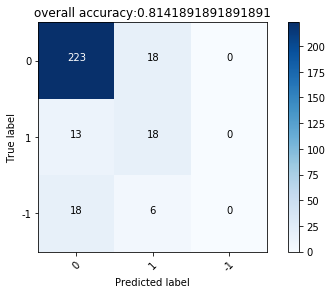

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       289
           1       0.00      0.00      0.00         3
          -1       0.00      0.00      0.00         4

   micro avg       0.97      0.97      0.97       296
   macro avg       0.33      0.33      0.33       296
weighted avg       0.95      0.97      0.96       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

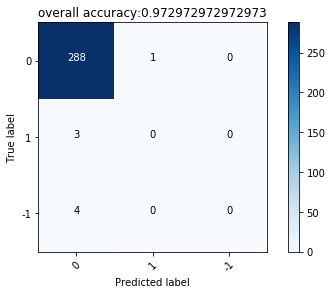

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task2
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       249
           1       0.00      0.00      0.00         4
          -1       0.00      0.00      0.00        43

   micro avg       0.83      0.83      0.83       296
   macro avg       0.28      0.33      0.30       296
weighted avg       0.71      0.83      0.77       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

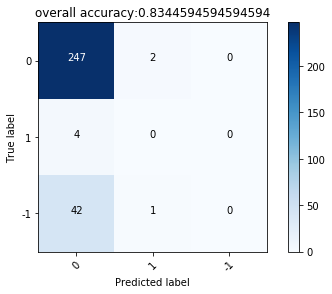

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task3
              precision    recall  f1-score   support

           0       0.68      0.99      0.80       196
           1       0.30      0.17      0.21        18
          -1       0.00      0.00      0.00        82

   micro avg       0.67      0.67      0.67       296
   macro avg       0.33      0.39      0.34       296
weighted avg       0.47      0.67      0.55       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

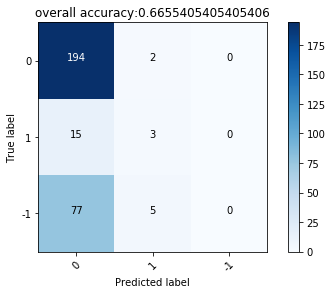

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task4
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       238
           1       0.46      0.22      0.30        27
          -1       0.00      0.00      0.00        31

   micro avg       0.80      0.80      0.80       296
   macro avg       0.43      0.40      0.40       296
weighted avg       0.70      0.80      0.74       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

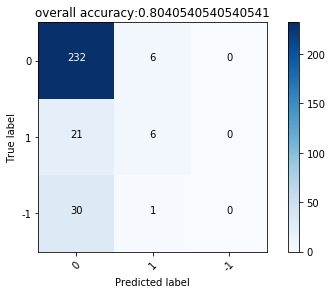

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task5
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.17      0.10      0.12        10
          -1       0.00      0.00      0.00         9

   micro avg       0.93      0.93      0.93       296
   macro avg       0.37      0.36      0.36       296
weighted avg       0.89      0.93      0.91       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

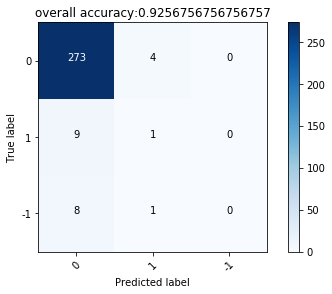

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task6
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       252
           1       0.00      0.00      0.00        15
          -1       0.00      0.00      0.00        29

   micro avg       0.85      0.85      0.85       296
   macro avg       0.28      0.33      0.31       296
weighted avg       0.72      0.85      0.78       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

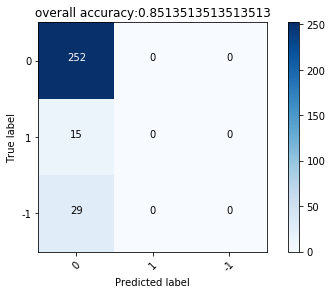

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task7
              precision    recall  f1-score   support

           0       0.69      0.97      0.81       186
           1       0.41      0.29      0.34        48
          -1       0.00      0.00      0.00        62

   micro avg       0.66      0.66      0.66       296
   macro avg       0.37      0.42      0.38       296
weighted avg       0.50      0.66      0.56       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

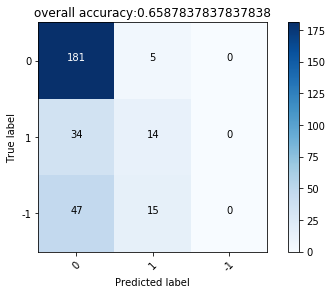

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task8
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       247
           1       0.14      0.04      0.06        25
          -1       0.00      0.00      0.00        24

   micro avg       0.82      0.82      0.82       296
   macro avg       0.33      0.34      0.32       296
weighted avg       0.71      0.82      0.76       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

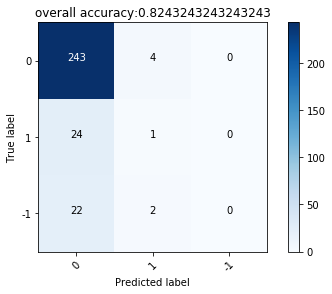

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task9
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       257
           1       0.67      0.20      0.31        10
          -1       0.00      0.00      0.00        29

   micro avg       0.88      0.88      0.88       296
   macro avg       0.51      0.40      0.41       296
weighted avg       0.78      0.88      0.82       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

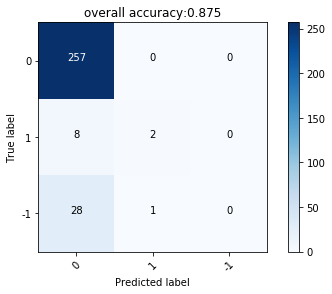

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task10
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       200
           1       0.33      0.37      0.35        38
          -1       0.00      0.00      0.00        58

   micro avg       0.69      0.69      0.69       296
   macro avg       0.36      0.44      0.40       296
weighted avg       0.55      0.69      0.61       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

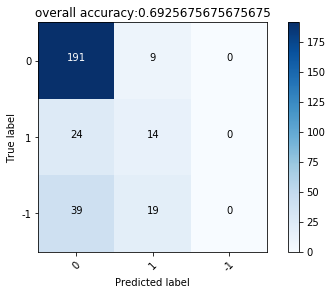

------------------------------------
out_dir: output_Tox21_test/predict/validation/confusion_matrix/task11
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       241
           1       0.37      0.25      0.30        28
          -1       0.00      0.00      0.00        27

   micro avg       0.81      0.81      0.81       296
   macro avg       0.40      0.40      0.40       296
weighted avg       0.72      0.81      0.76       296

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

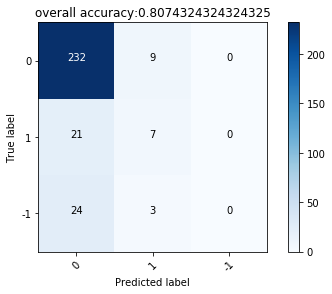

CPU times: user 49.8 s, sys: 6.96 s, total: 56.8 s
Wall time: 55.2 s


<Figure size 432x288 with 0 Axes>

In [15]:
%%time
# -------- 推論 --------
model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/validation')

# 出力層のニューラルネットワークに分岐がない場合のpredict
y_valid_list, y_pred_list = multi_predict.no_branch_set_predict(model, d_cls.X_valid, d_cls.y_valid, out_predict_dir)

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
classes = [0,1,-1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(classes, y_valid_list, y_pred_list, out_predict_dir)

------------------------------------
out_png: output_Tox21_test/predict/validation/ROC_curve.png


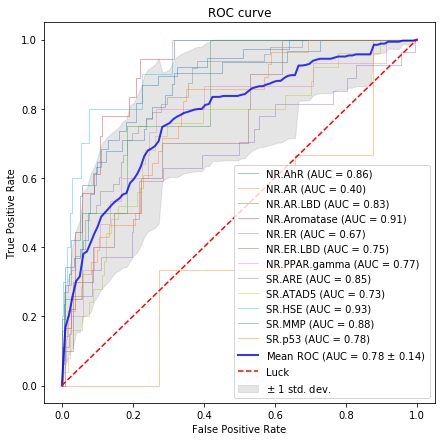

<Figure size 432x288 with 0 Axes>

In [16]:
# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_valid_list, y_pred_list)

### validation set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/../predicter/grad_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()# camのピクセルの値を0-1に正規化


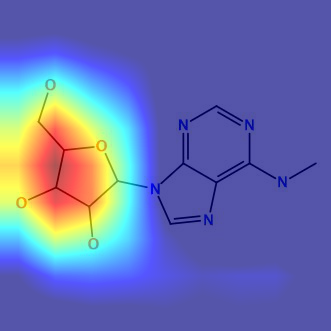

In [17]:
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation')

model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_valid[0]*255.0
input_img_name = 'valid0'

y_true = d_cls.y_valid[0]

# 1画像について各タスクのGradCamを計算
grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### validation set 全件GradCam実行（数時間かかる）

input_img_name: NCGC00261443-01_000.jpg


/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/../predicter/grad_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()# camのピクセルの値を0-1に正規化


input_img_name: NCGC00261600-01_000.jpg
input_img_name: NCGC00260926-01_000.jpg
input_img_name: NCGC00261266-01_000.jpg
input_img_name: NCGC00261897-01_000.jpg
input_img_name: NCGC00261559-01_000.jpg
input_img_name: NCGC00261121-01_000.jpg
input_img_name: NCGC00261374-01_000.jpg
input_img_name: NCGC00261612-01_000.jpg
input_img_name: NCGC00261002-01_000.jpg
input_img_name: NCGC00261311-01_000.jpg
input_img_name: NCGC00261257-01_000.jpg
input_img_name: NCGC00260836-01_000.jpg
input_img_name: NCGC00261756-01_000.jpg
input_img_name: NCGC00261491-01_000.jpg
input_img_name: NCGC00261502-01_000.jpg
input_img_name: NCGC00261552-01_000.jpg
input_img_name: NCGC00261763-01_000.jpg
input_img_name: NCGC00260832-01_000.jpg
input_img_name: NCGC00260772-01_000.jpg
input_img_name: NCGC00261543-01_000.jpg
input_img_name: NCGC00261174-01_000.jpg
input_img_name: NCGC00261524-01_000.jpg
input_img_name: NCGC00261099-01_000.jpg
input_img_name: NCGC00261743-01_000.jpg
input_img_name: NCGC00261301-01_000.jpg


input_img_name: NCGC00261016-01_000.jpg
input_img_name: NCGC00260855-01_000.jpg
input_img_name: NCGC00261359-01_000.jpg
input_img_name: NCGC00261622-01_000.jpg
input_img_name: NCGC00261035-01_000.jpg
input_img_name: NCGC00260819-01_000.jpg
input_img_name: NCGC00260699-01_000.jpg
input_img_name: NCGC00261421-01_000.jpg
input_img_name: NCGC00261386-01_000.jpg
input_img_name: NCGC00261685-01_000.jpg
input_img_name: NCGC00261712-01_000.jpg
input_img_name: NCGC00261467-01_000.jpg
input_img_name: NCGC00260967-01_000.jpg
input_img_name: NCGC00260985-01_000.jpg
input_img_name: NCGC00261225-01_000.jpg
input_img_name: NCGC00261905-01_000.jpg
input_img_name: NCGC00260765-01_000.jpg
input_img_name: NCGC00260701-01_000.jpg
input_img_name: NCGC00260741-01_000.jpg
input_img_name: NCGC00261855-01_000.jpg
input_img_name: NCGC00260843-01_000.jpg
input_img_name: NCGC00260895-01_000.jpg
input_img_name: NCGC00261358-01_000.jpg
input_img_name: NCGC00261957-01_000.jpg
input_img_name: NCGC00260861-01_000.jpg


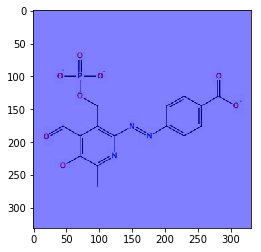

CPU times: user 14h 13min 31s, sys: 25min 40s, total: 14h 39min 11s
Wall time: 14h 25min 21s


In [18]:
%%time
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation_all')

model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

for i,  x in enumerate(d_cls.X_valid):
    # 3次元numpy.array型の画像データ（*1./255.前）
    x = x*255.0
    
    # ファイル名
    file_path = validation_files[validation_files.index[i]]# validation_filesはindexが0始まりではないので.index[i]で要素アクセス
    input_img_name = os.path.basename(file_path)
    print('input_img_name:', input_img_name)
    
    # 正解ラベル
    y_true = d_cls.y_valid[i]

    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()